In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [366]:
def get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr):
    species_df = state_df[state_df['Species_id'] == species_id]
    species_df = species_df[species_df['Year'] == year]
    species_df = species_df[species_df[attr] >= 0]
    pcts = []
    for week in range(48):
        species_df_week = species_df[species_df['Week'] == week]
        N = len(species_df_week)
        if N == 0:
            pcts.append(0)
        else:
            species_df_week_observed = species_df_week[species_df_week[attr] > 0]
            pcts.append(len(species_df_week_observed) / N)
    return pcts

In [367]:
def num_observations(state_df, year, week, species_id, attr):
    species_df = state_df[state_df['Species_id'] == species_id]
    species_df = species_df[species_df['Year'] == year]
    species_df = species_df[species_df[attr] >= 0]
    species_df_week = species_df[species_df['Week'] == week]
    return len(species_df_week)

In [414]:
def get_scores(state_df, species_id, attr, L=5, M=3, w_1=1, w_2=1):
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores = []
    stagns = []
    spikes = []
    for week in range(L, len(pcts)-M, 1): # todo - calculate score for weeks before week L
        #print(pcts[week-L:week+1])
        stagn = 1 / (0.01 + max(pcts[week-L:week+1]) - min(pcts[week-L:week+1]))
        # if stagn < 5:
        #     stagn = 0
        
        differences_arr = np.array([pcts[k + 1] - pcts[k] for k in range(week, week+M, 1)])
        spike = np.prod(np.exp(differences_arr))
        # calculate spike based on net change
        # diff = pcts[week + M] - pcts[week]
        # spike = np.exp(5*diff)
        
        spikes.append(spike)
        stagns.append(stagn)
    #print(scores)
    spikes = 100 * (np.array(spikes) - np.min(spikes)) / np.max(spikes)
    scores = 0.5 * (w_1 * np.array(spikes) + w_2 * np.array(stagns))
    return list(scores), list(spikes), list(stagns)

In [415]:
def plot_score_and_pcts(species_id, attr, L=5, M=3, w_1=1, w_2=1):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)

    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    #print(scores)
    print(f"len scores {len(scores)}, len pcts {len(pcts)}")
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label=f'percent of observations observing {attr}')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2, label='mean transition times')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    twin.bar(range(len(pcts)), scores, label='unnormalized week score', alpha=0.25)
    twin.set(ylabel='score')
    plt.title(f"Mango (all species), {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}")
    twin.legend(loc='upper right')
    plt.show()

    for idx, year in enumerate(list(range(2018, 2024))):
        fig, ax = plt.subplots()
        ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
        ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
        ax.legend(loc = 'lower left')
        ax.set(xlabel='week', ylabel='percent of observations')
        twin = ax.twinx()
        scores_for_year = scores[48*idx:48*idx+48].copy()
        probs_for_year = scores_for_year / np.sum(scores_for_year)
        #print(probs_for_year)
        twin.bar(range(48), probs_for_year, label='probability of week being a transition week', alpha=0.25)
        twin.legend(loc='upper right')
        twin.set(ylabel='score')
        plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

In [416]:
def plot_score_for_one_year(year, species_id, attr, L=5, M=3, w_1=1, w_2=1):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for y in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, y, species_id, attr)
    scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)

    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    #print(scores)
    print(f"len scores {len(scores)}, len pcts {len(pcts)}")
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))

    idx = year - 2018
    fig, ax = plt.subplots()
    ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
    ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
    ax.legend(loc = 'lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    scores_for_year = scores[48*idx:48*idx+48].copy()
    probs_for_year = scores_for_year / np.sum(scores_for_year)
    twin.bar(range(48), probs_for_year, label='probability of week being a transition week', alpha=0.25)
    twin.legend(loc='upper right')
    twin.set(ylabel='score')
    plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

In [417]:
def plot_stagnations(species_id, attr, L=5, M=3, w_1=1, w_2=1):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)

    stagns = np.array([0 for i in range(L)] + stagns + [0 for i in range(M)])
    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label=f'percent of observations observing {attr}')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2, label='mean transition times')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    twin.bar(range(len(pcts)), stagns, label='unnormalized week stagnation', alpha=0.25)
    twin.set(ylabel='score')
    plt.title(f"Mango (all species), {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}")
    twin.legend(loc='upper right')
    plt.show()

    for idx, year in enumerate(list(range(2018, 2024))):
        fig, ax = plt.subplots()
        ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
        ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
        ax.legend(loc = 'lower left')
        ax.set(xlabel='week', ylabel='percent of observations')
        twin = ax.twinx()
        stagns_for_year = stagns[48*idx:48*idx+48].copy()
        #print(probs_for_year)
        twin.bar(range(48), stagns_for_year, label='stagnation', alpha=0.25)
        twin.legend(loc='upper right')
        twin.set(ylabel='score')
        plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

def plot_spikes(species_id, attr, L=5, M=3, w_1=1, w_2=1):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)

    spikes = np.array([0 for i in range(L)] + spikes + [0 for i in range(M)])
    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label=f'percent of observations observing {attr}')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2, label='mean transition times')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    twin.bar(range(len(pcts)), spikes, label='unnormalized week spike', alpha=0.25)
    twin.set(ylabel='score')
    plt.title(f"Mango (all species), {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}")
    twin.legend(loc='upper right')
    plt.show()

    for idx, year in enumerate(list(range(2018, 2024))):
        fig, ax = plt.subplots()
        ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
        ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
        ax.legend(loc = 'lower left')
        ax.set(xlabel='week', ylabel='percent of observations')
        twin = ax.twinx()
        spikes_for_year = spikes[48*idx:48*idx+48].copy()
        #print(probs_for_year)
        twin.bar(range(48), spikes_for_year, label='unnormalized week spike', alpha=0.25)
        twin.legend(loc='upper right')
        twin.set(ylabel='score')
        plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

len scores 288, len pcts 288


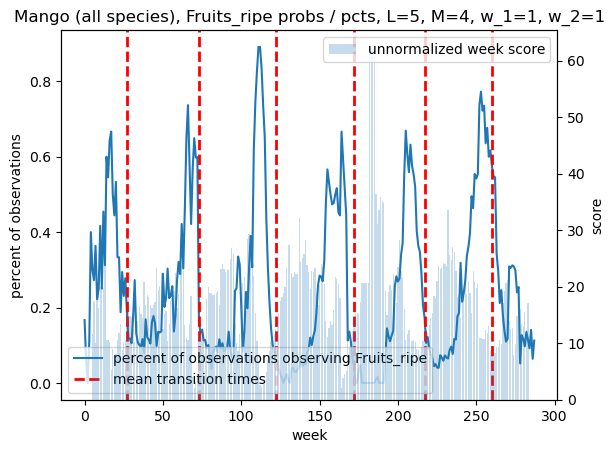

len scores 288, len pcts 288


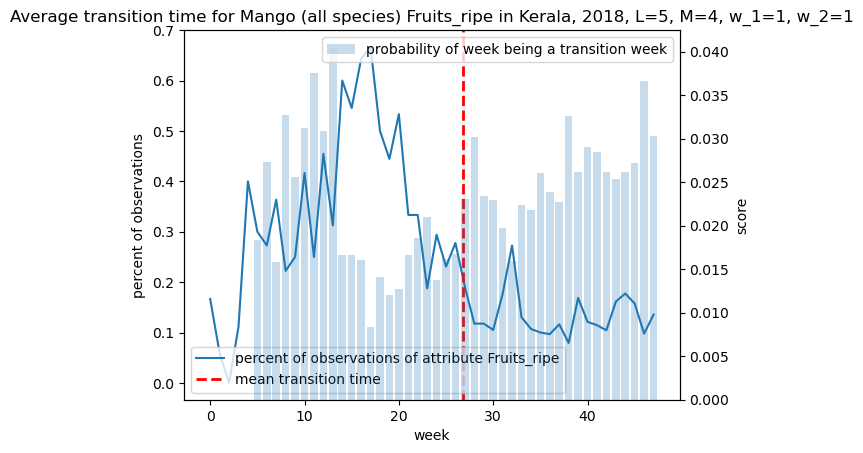

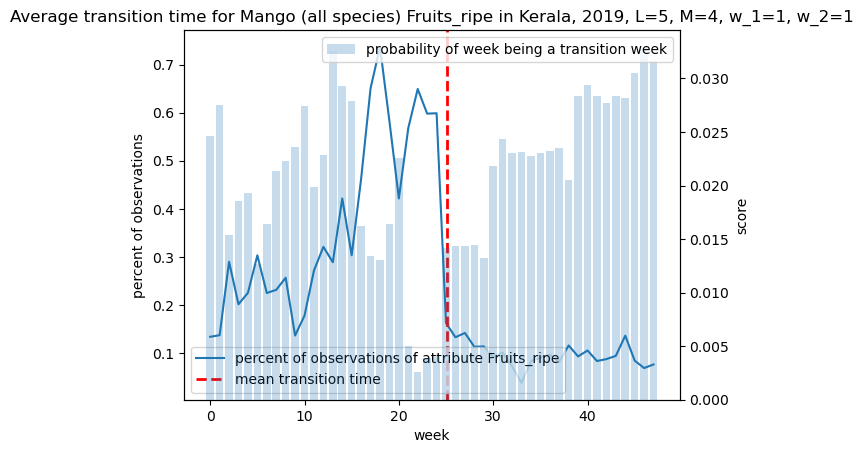

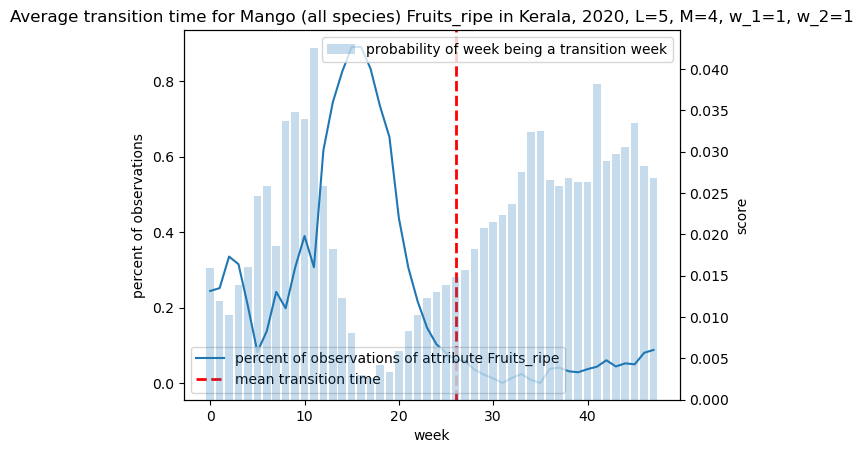

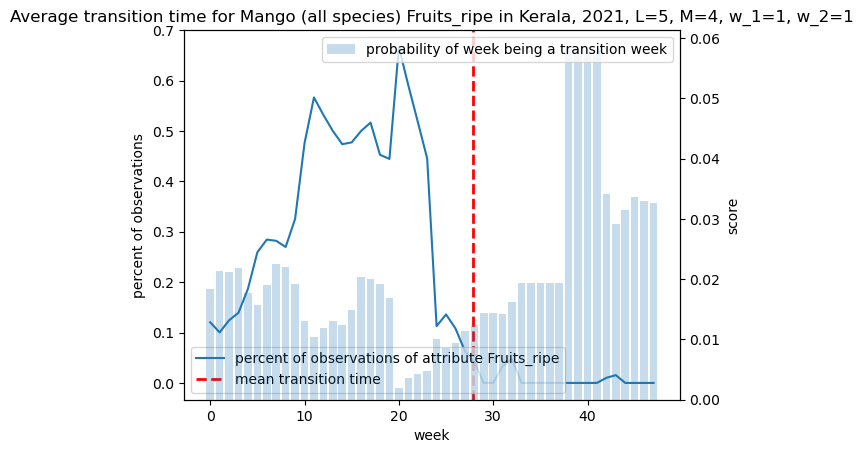

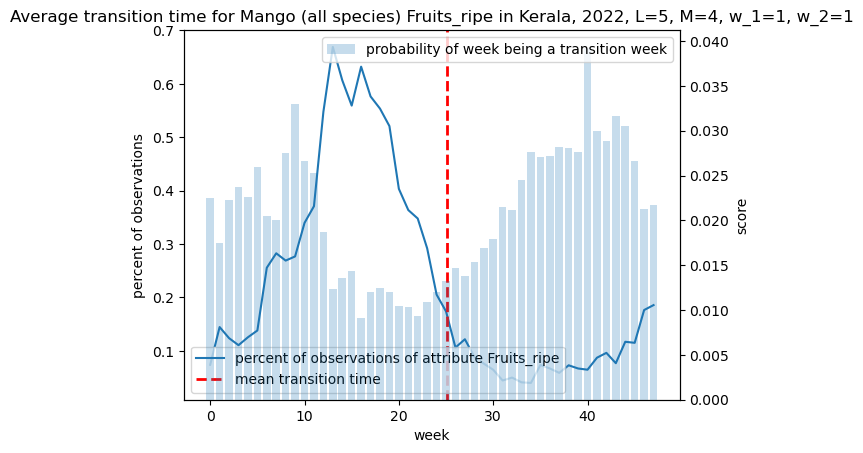

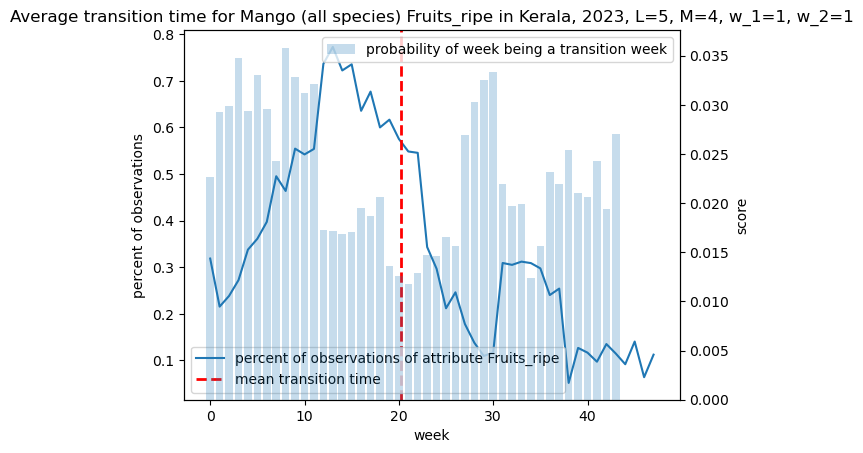

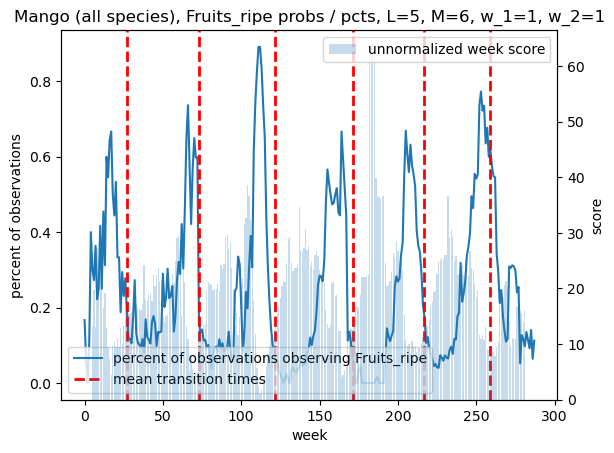

len scores 288, len pcts 288


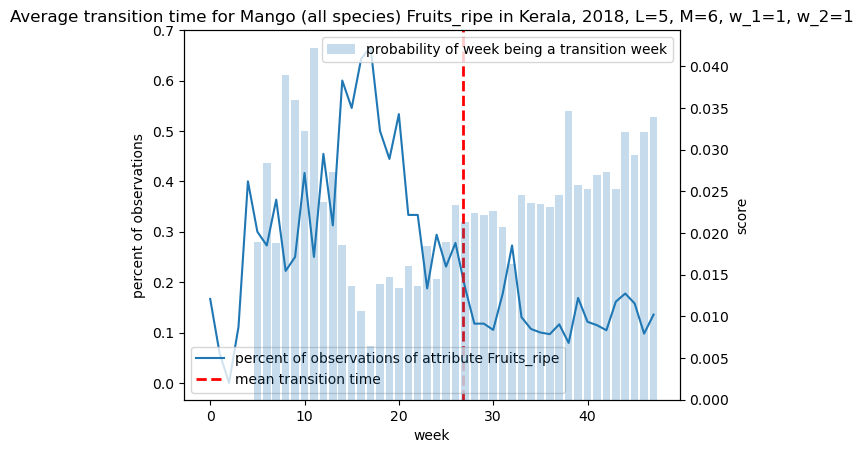

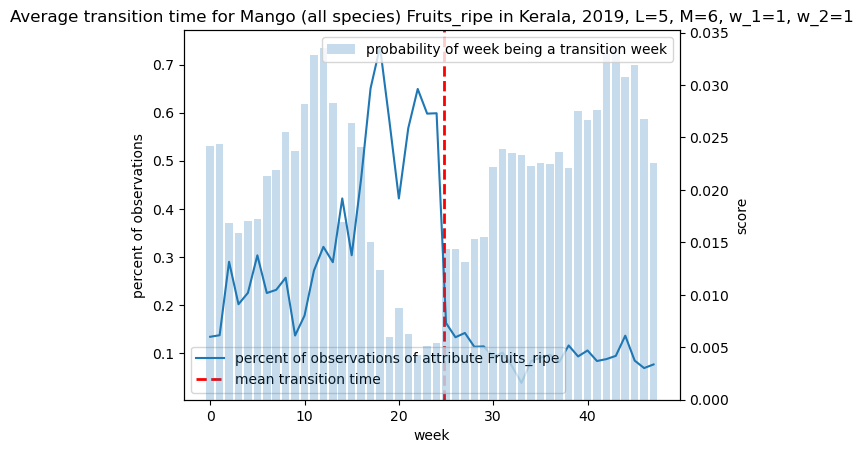

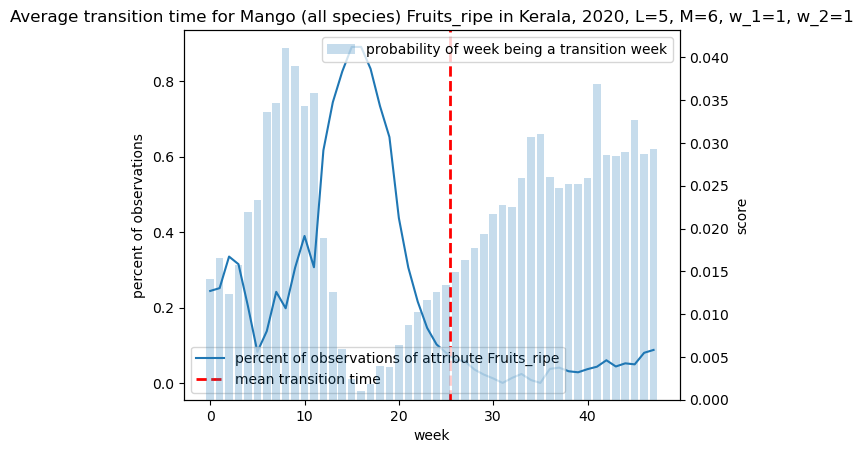

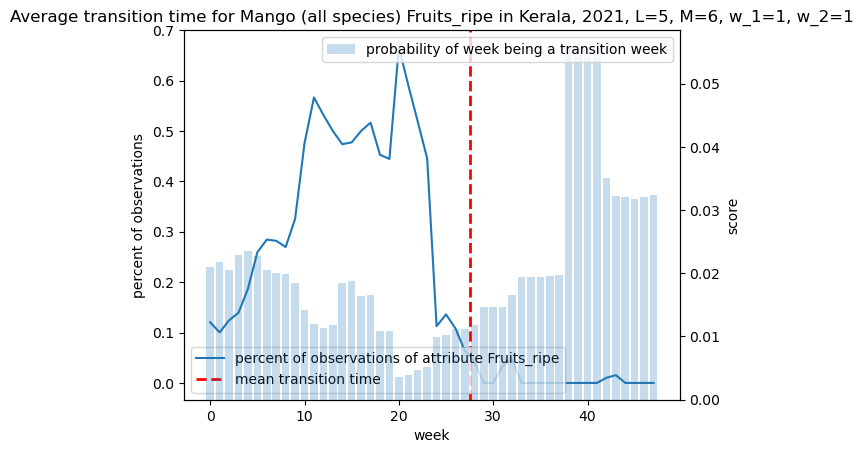

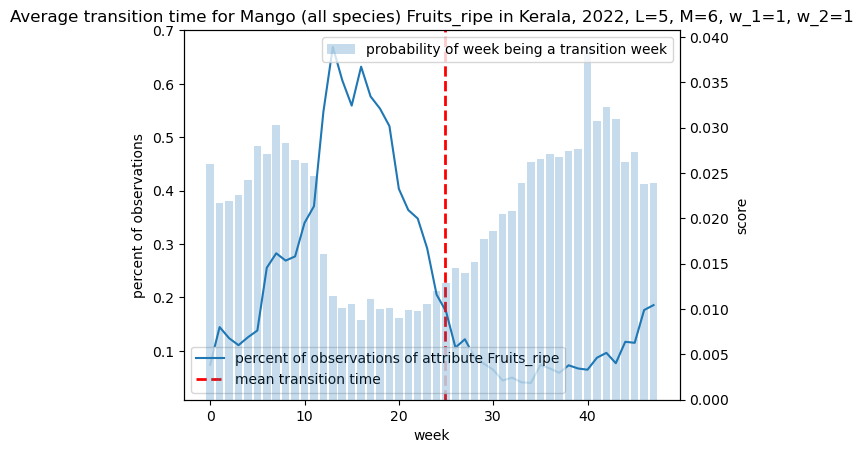

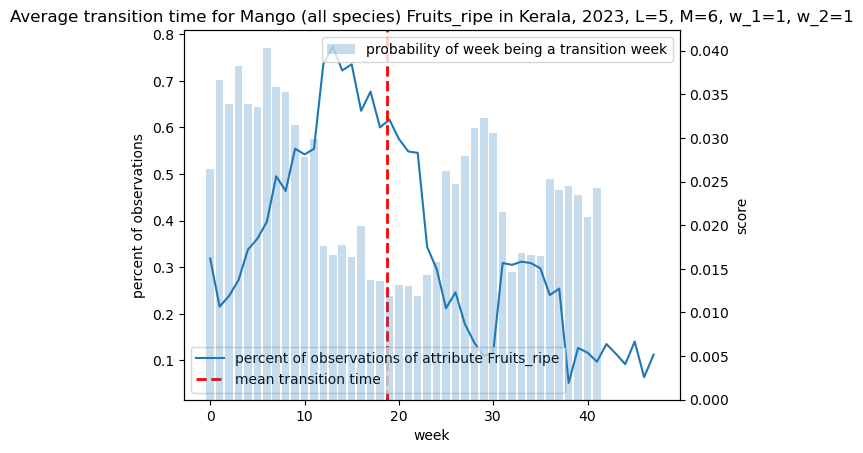

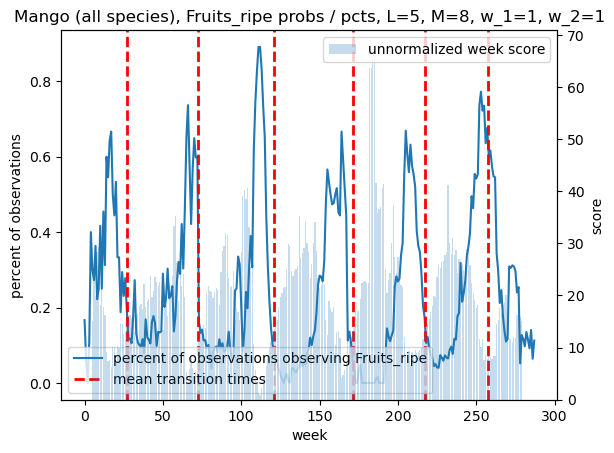

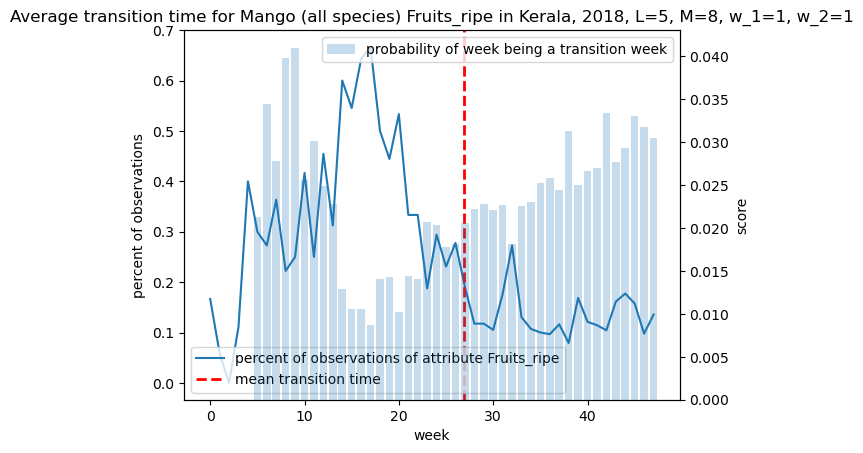

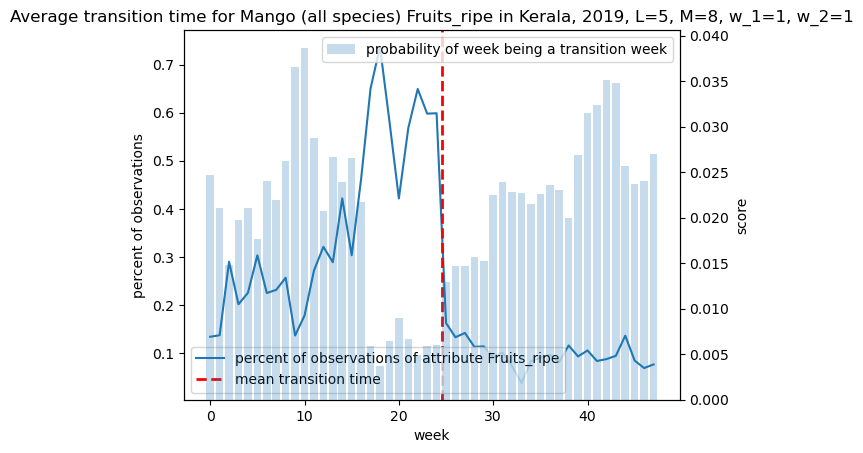

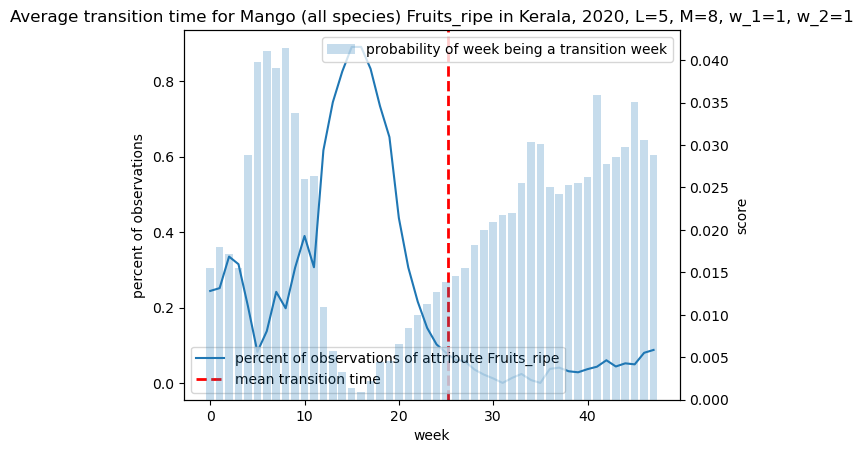

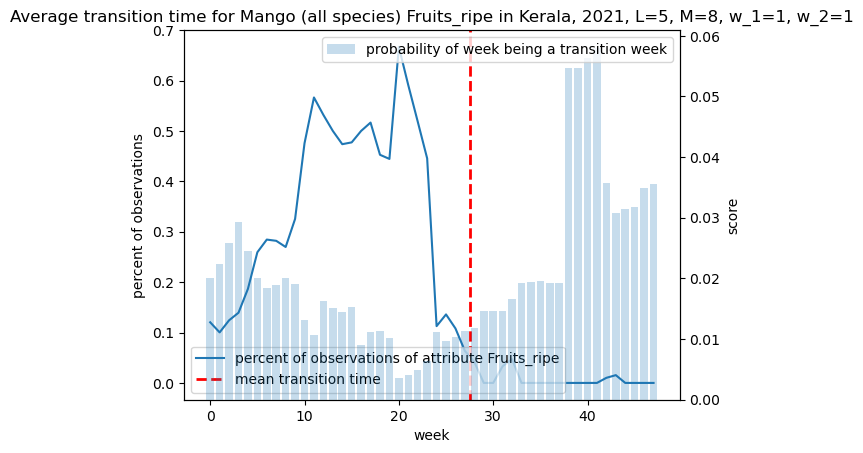

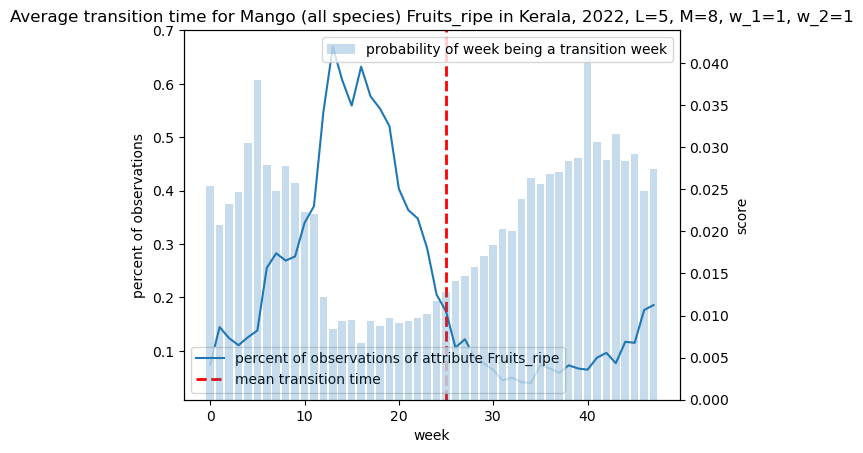

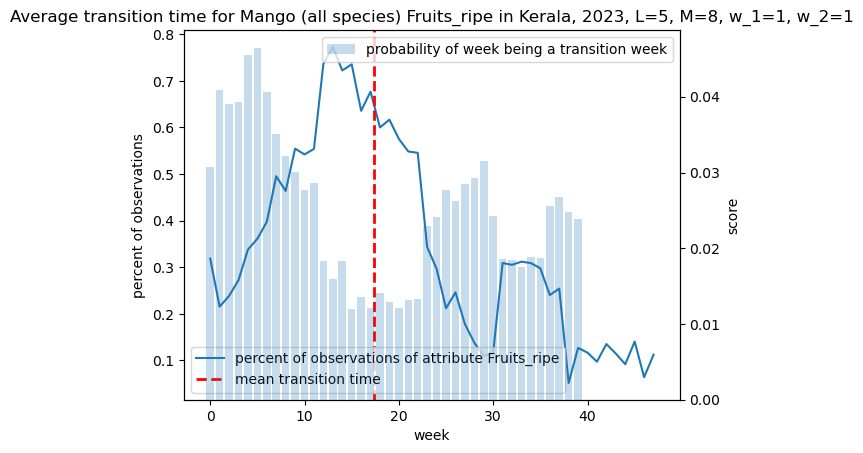

In [419]:
# looks great except for 2023!
year = 2022
for w_1 in [1]:
    for w_2 in [1]:
        for M in [4, 6, 8]:
            for attr in ['Fruits_ripe']:
                # plot_stagnations(species_id, attr, L=5, M=M, w_1=w_1, w_2=w_2)
                # plot_spikes(species_id, attr, L=5, M=M, w_1=w_1, w_2=w_2)
                plot_score_and_pcts(species_id, attr, L=5, M=M, w_1=w_1, w_2=w_2)
                #plot_score_for_one_year(year, 1161, attr, L=5, M=M, w_1=w_1, w_2=w_2)